## Learning Objectives

At the end of the experiment, you will be able to : 
* Understand the VGG16 pre-trained model to classify Retinal damage from OCT scans

In [ ]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="850" height="480" controls>
  <source src="https://cdn.talentsprint.com/talentsprint1/archives/sc/misc/vgg16_pretrained_model.mp4" type="video/mp4">
</video>
""")

## Dataset

### History

#### OCTR

Retinal optical coherence tomography (OCT) is an imaging technique that uses coherent light to capture high-resolution of biological tissues. OCT is heavily used by ophthalmologists to obtain high resolution images of the eye retina. Retina of the eye functions much more like a film in a camera. OCT images can be used to diagnose many retina related eyes diseases.

OCT testing has become a standard of care for the assessment and treatment of most retinal conditions. OCT uses rays of light to measure retinal thickness. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time. 





#### Description

The dataset contains subfolders for each image category (NORMAL, CNV, DME, DRUSEN). There are 8054 training X-Ray images (JPEG) and 1000 X-Ray images for testing with 4 categories (NORMAL, CNV, DME, DRUSEN).

Images are labeled as (disease)-(randomized patient ID)-(image number by this patient) and split into 4 directories: CNV, DME, DRUSEN, and NORMAL

![alt text](https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/Images/OCTR.jpg)


There are four classes in retinal oct images.They are:

1) Choroidal Neovascularization (CNV) : CNV is the creation of new blood vessels in the choroid layer of the eye. 

2) Diabetic Macular Edema (DME) : DME is an accumulation of fluid in the macula — part of the retina that controls our most detailed vision abilities — due to leaking blood vessels.

3) Drusen (DRUSEN) : Drusen are yellow deposits under the retina. Drusen are made up of lipids, a fatty protein. Drusen likely do not cause age-related macular degeneration (AMD).

4) Normal Eye Retina (NORMAL) : Normal retina with preserved foveal contour and absence of any retinal fluid/edema.



### VGG16

The VGG16- convolutional network, is trained on ImageNet dataset (1000 classes) which is capable of extracting features from an image and train its fully connected network in order to classify different types of retinal damage instead of objects.

In [ ]:
! wget https://cdn.iiith.talentsprint.com/aiml/Experiment_related_data/OCT2017.zip
! unzip OCT2017.zip

### 1. Importing the required packages

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms, models
import torch.optim as optim

### 2. Data Loading and Pre-processing

In [ ]:
transformations = transforms.Compose([
                                      transforms.Resize((224, 224)), # Resize the image to 224×224 pixels.
                                      transforms.ToTensor(),         # Convert the image to PyTorch Tensor                                                                        # Normalize the image
                                    ])

In [ ]:
trainset = datasets.ImageFolder('/content/OCT2017/Train', transform = transformations)

testset = datasets.ImageFolder('/content/OCT2017/Test', transform = transformations)


# Load the data. utils.dataloader is a package for loading the dataset 
train_loader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=10)
test_loader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=10)

In [ ]:
len(trainset)

8054

In [ ]:
# Mapping the name of the class to index
trainset.class_to_idx

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

In [ ]:
# Data Loader
train_loader.dataset

Dataset ImageFolder
    Number of datapoints: 8054
    Root location: /content/OCT2017/Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [ ]:
# To print the size of Images
# Get a batch of training data
current_Images, current_labels = next(iter(train_loader))
current_Images[1].shape

torch.Size([3, 224, 224])

In [ ]:
# Print the labels 
current_labels

tensor([3, 0, 0, 1, 0, 1, 1, 1, 0, 1])

### 3. Plotting the sample Images

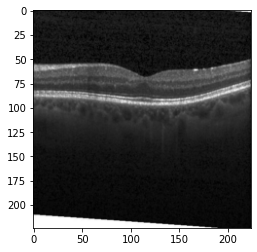

In [ ]:
plt.imshow(current_Images[0].permute(1, 2, 0));

### 4. Applying VGG16

In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In the last layer of the classifier the VGG-16 is able to classify 1000 different labels but you just need 4 labels instead. In order to do that replace the last fully connected layer of the model with a new one with 4 output features instead of 1000.

In PyTorch, we can access the VGG-16 classifier with model.classifier, which is an 6-layer array. 



In [ ]:
# Print the input features of 6th module from the classifier
num_features = vgg16.classifier[6].in_features
print(num_features)

4096


In [ ]:
# Remove last layer
features = list(vgg16.classifier.children())[:-1] 
print(features)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False)]


In [ ]:
# Add the linear layer with 4 outputs
features.extend([nn.Linear(num_features, 4)])
print(features) 

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4, bias=True)]


In [ ]:
# Replace the model classifier
vgg16.classifier = nn.Sequential(*features) 
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

The output above is the summary of our model. Notice that the last layer has 4 output features as we have 4 ouput classes

### 5. Predicting the label of the given Image

In [ ]:
image = current_Images[0].unsqueeze(0)
output = vgg16(image)
_, predicted = torch.max(output, 1)
trainset.classes[predicted.item()], predicted

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


('NORMAL', tensor([3]))

### 6. Initializing CUDA

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### 7. Defining the Criterion and the Loss Function

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(vgg16.parameters(), lr=0.003, momentum=0.9)

vgg16 = vgg16.to(device)

### 8. Training the model

The below code cell takes 20 mins to run


In [ ]:
# This code cell takes 20 mins to run

# No of Epochs
epoch = 5

# keeping the network in train mode
vgg16.train()
train_losses,  train_accuracy = [], []

# Loop for no of epochs
for e in range(epoch):
    train_loss = 0
    correct = 0
    # Iterate through all the batches in each epoch
    for images, labels in train_loader:

      # Convert the image and label to gpu for faster execution
      images = images.to(device)
      labels = labels.to(device)

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Passing the data to the model (Forward Pass)
      outputs = vgg16(images)

      # Calculating the loss
      loss = criterion(outputs, labels)
      train_loss += loss.item()

      # Performing backward pass (Backpropagation)
      loss.backward()

      # optimizer.step() updates the weights accordingly
      optimizer.step()

      # Accuracy calculation
      _, predicted = torch.max(outputs, 1)
      correct += (predicted == labels).sum().item()

    train_losses.append(train_loss/len(trainset))
    train_accuracy.append(100 * correct/len(trainset))
    print('epoch: {}, Train Loss:{:.6f} Train Accuracy: {:.2f} '.format(e+1,train_losses[-1], train_accuracy[-1]))

### 9. Model Evaluation

In [ ]:
# Keeping the network in evaluation mode 
vgg16.eval()  

Test_accuracy = 0

# Iterate through all the batches in each epoch
for images,labels in test_loader:
    # Convert the images and labels to gpu for faster execution
    images = images.to(device)
    labels = labels.to(device)

    # Do the forward pass 
    outputs = vgg16(images)

    # Accuracy calculation
    _, predicted = torch.max(outputs, 1)
    Test_accuracy += (predicted == labels).sum().item()

Accuracy = 100 * Test_accuracy / len(testset)
print("Accuracy of Test Data is", Accuracy)